<a href="https://colab.research.google.com/github/1012598167/cs231n/blob/main/svm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from google.colab import drive

drive.mount('/content/drive', force_remount=True)

# 输入daseCV所在的路径
# 'daseCV' 文件夹包括 '.py', 'classifiers' 和'datasets'文件夹
# 例如 'CV/assignments/assignment1/daseCV/'
FOLDERNAME = 'CV/assignments/assignment1/daseCV/'

assert FOLDERNAME is not None, "[!] Enter the foldername."

%cd drive/My\ Drive
%cp -r $FOLDERNAME ../../
%cd ../../
%cd daseCV/datasets/
!bash get_datasets.sh
%cd ../../

Mounted at /content/drive
/content/drive/My Drive
/content
/content/daseCV/datasets
--2021-04-04 00:36:27--  http://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz
Resolving www.cs.toronto.edu (www.cs.toronto.edu)... 128.100.3.30
Connecting to www.cs.toronto.edu (www.cs.toronto.edu)|128.100.3.30|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 170498071 (163M) [application/x-gzip]
Saving to: ‘cifar-10-python.tar.gz’

cifar-10-python.tar 100%[===================>] 162.60M  97.6MB/s    in 1.7s    

2021-04-04 00:36:29 (97.6 MB/s) - ‘cifar-10-python.tar.gz’ saved [170498071/170498071]

cifar-10-batches-py/
cifar-10-batches-py/data_batch_4
cifar-10-batches-py/readme.html
cifar-10-batches-py/test_batch
cifar-10-batches-py/data_batch_3
cifar-10-batches-py/batches.meta
cifar-10-batches-py/data_batch_2
cifar-10-batches-py/data_batch_5
cifar-10-batches-py/data_batch_1
/content


# 多分类支撑向量机练习
*完成此练习并且上交本ipynb（包含输出及代码）.*

在这个练习中，你将会:
    
- 为SVM构建一个完全向量化的**损失函数**
- 实现**解析梯度**的向量化表达式
- 使用数值梯度检查你的代码是否正确
- 使用验证集**调整学习率和正则化项**
- 用**SGD（随机梯度下降）** **优化**损失函数
- **可视化** 最后学习到的权重


In [3]:
# 导入包
import random
import numpy as np
from daseCV.data_utils import load_CIFAR10
import matplotlib.pyplot as plt

# 下面一行是notebook的magic命令，作用是让matplotlib在notebook内绘图（而不是新建一个窗口）
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # 设置绘图的默认大小
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# 该magic命令可以重载外部的python模块
# 相关资料可以去看 http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

## 准备和预处理CIFAR-10的数据

In [4]:
# 导入原始CIFAR-10数据
cifar10_dir = 'daseCV/datasets/cifar-10-batches-py'

# 清空变量，防止多次定义变量（可能造成内存问题）
try:
   del X_train, y_train
   del X_test, y_test
   print('Clear previously loaded data.')
except:
   pass

X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)

# 完整性检查，打印出训练和测试数据的大小
print('Training data shape: ', X_train.shape)
print('Training labels shape: ', y_train.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)

Training data shape:  (50000, 32, 32, 3)
Training labels shape:  (50000,)
Test data shape:  (10000, 32, 32, 3)
Test labels shape:  (10000,)


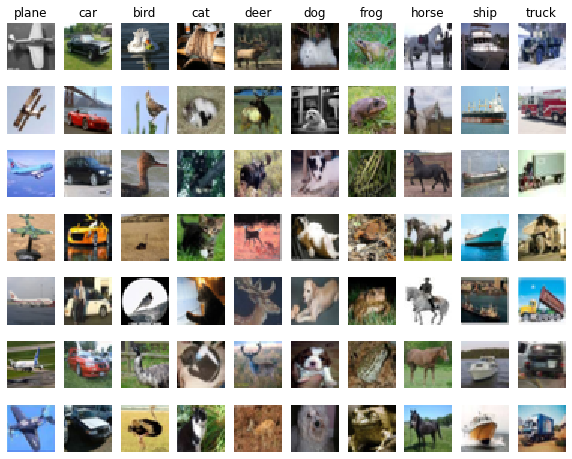

In [5]:
# 可视化部分数据
# 这里我们每个类别展示了7张图片
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
num_classes = len(classes)
samples_per_class = 7
for y, cls in enumerate(classes):
    idxs = np.flatnonzero(y_train == y)
    idxs = np.random.choice(idxs, samples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt_idx = i * num_classes + y + 1
        plt.subplot(samples_per_class, num_classes, plt_idx)
        plt.imshow(X_train[idx].astype('uint8'))
        plt.axis('off')
        if i == 0:
            plt.title(cls)
plt.show()

In [6]:
# 划分训练集，验证集和测试集，除此之外，
# 我们从训练集中抽取了一小部分作为代码开发的数据，
# 使用小批量的开发数据集能够快速开发代码
num_training = 49000
num_validation = 1000
num_test = 1000
num_dev = 500

# 从原始训练集中抽取出num_validation个样本作为验证集
mask = range(num_training, num_training + num_validation)
X_val = X_train[mask]
y_val = y_train[mask]

# 从原始训练集中抽取出num_training个样本作为训练集
mask = range(num_training)
X_train = X_train[mask]
y_train = y_train[mask]

# 从训练集中抽取num_dev个样本作为开发数据集
mask = np.random.choice(num_training, num_dev, replace=False)
X_dev = X_train[mask]
y_dev = y_train[mask]

# 从原始测试集中抽取num_test个样本作为测试集
mask = range(num_test)
X_test = X_test[mask]
y_test = y_test[mask]

print('Train data shape: ', X_train.shape)
print('Train labels shape: ', y_train.shape)
print('Validation data shape: ', X_val.shape)
print('Validation labels shape: ', y_val.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)

Train data shape:  (49000, 32, 32, 3)
Train labels shape:  (49000,)
Validation data shape:  (1000, 32, 32, 3)
Validation labels shape:  (1000,)
Test data shape:  (1000, 32, 32, 3)
Test labels shape:  (1000,)


In [7]:
# 预处理：把图片数据rehspae成行向量
X_train = np.reshape(X_train, (X_train.shape[0], -1))
X_val = np.reshape(X_val, (X_val.shape[0], -1))
X_test = np.reshape(X_test, (X_test.shape[0], -1))
X_dev = np.reshape(X_dev, (X_dev.shape[0], -1))

# 完整性检查，打印出数据的shape
print('Training data shape: ', X_train.shape)
print('Validation data shape: ', X_val.shape)
print('Test data shape: ', X_test.shape)
print('dev data shape: ', X_dev.shape)

Training data shape:  (49000, 3072)
Validation data shape:  (1000, 3072)
Test data shape:  (1000, 3072)
dev data shape:  (500, 3072)


[130.64189796 135.98173469 132.47391837 130.05569388 135.34804082
 131.75402041 130.96055102 136.14328571 132.47636735 131.48467347]


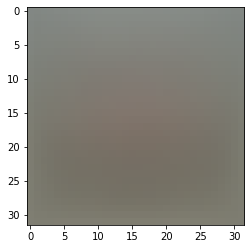

(49000, 3073) (1000, 3073) (1000, 3073) (500, 3073)


In [8]:
# 预处理：减去image的平均值（均值规整化）
# 第一步：计算训练集中的图像均值
mean_image = np.mean(X_train, axis=0)
print(mean_image[:10]) # print a few of the elements
plt.figure(figsize=(4,4))
plt.imshow(mean_image.reshape((32,32,3)).astype('uint8')) # visualize the mean image
plt.show()

# 第二步：所有数据集减去均值
X_train -= mean_image
X_val -= mean_image
X_test -= mean_image
X_dev -= mean_image

# 第三步：拼接一个bias维，其中所有值都是1（bias trick），
# SVM可以联合优化数据和bias，即只需要优化一个权值矩阵W
X_train = np.hstack([X_train, np.ones((X_train.shape[0], 1))])
X_val = np.hstack([X_val, np.ones((X_val.shape[0], 1))])
X_test = np.hstack([X_test, np.ones((X_test.shape[0], 1))])
X_dev = np.hstack([X_dev, np.ones((X_dev.shape[0], 1))])

print(X_train.shape, X_val.shape, X_test.shape, X_dev.shape)

## SVM分类器

你需要在**daseCV/classifiers/linear_svm.py**里面完成编码

我们已经预先定义了一个函数`compute_loss_naive`，该函数使用循环来计算多分类SVM损失函数

In [9]:
# 调用朴素版的损失计算函数
from daseCV.classifiers.linear_svm import svm_loss_naive
import time

# 生成一个随机的SVM权值矩阵（矩阵值很小）
W = np.random.randn(3073, 10) * 0.0001 

loss, grad = svm_loss_naive(W, X_dev, y_dev, 0.000005)
print('loss: %f' % (loss, ))

loss: 9.038591


从上面的函数返回的`grad`现在是零。请推导支持向量机损失函数的梯度，并在svm_loss_naive中编码实现。

为了检查是否正确地实现了梯度，你可以用数值方法估计损失函数的梯度，并将数值估计与你计算出来的梯度进行比较。我们已经为你提供了检查的代码:

In [10]:
# 一旦你实现了梯度计算的功能，重新执行下面的代码检查梯度

# 计算损失和W的梯度
loss, grad = svm_loss_naive(W, X_dev, y_dev, 0.0)

# 数值估计梯度的方法沿着随机几个维度进行计算，并且和解析梯度进行比较，
# 这两个方法算出来的梯度应该在任何维度上完全一致(相对误差足够小)
from daseCV.gradient_check import grad_check_sparse
f = lambda w: svm_loss_naive(w, X_dev, y_dev, 0.0)[0]
grad_numerical = grad_check_sparse(f, W, grad)

# 把正则化项打开后继续再检查一遍梯度
# 你没有忘记正则化项吧？（忘了的罚抄100遍(๑•́ ₃•̀๑) ）
loss, grad = svm_loss_naive(W, X_dev, y_dev, 5e1)
f = lambda w: svm_loss_naive(w, X_dev, y_dev, 5e1)[0]
grad_numerical = grad_check_sparse(f, W, grad)

numerical: 4.265196 analytic: 4.265196, relative error: 4.927737e-11
numerical: 21.235964 analytic: 21.235964, relative error: 2.012449e-11
numerical: 27.872397 analytic: 27.872397, relative error: 3.624871e-12
numerical: -15.504110 analytic: -15.504110, relative error: 6.204659e-12
numerical: -34.820109 analytic: -34.820109, relative error: 4.803291e-12
numerical: -33.164672 analytic: -33.164672, relative error: 5.726069e-12
numerical: 37.301622 analytic: 37.301622, relative error: 3.169207e-12
numerical: 0.072094 analytic: 0.072094, relative error: 7.526198e-10
numerical: 7.796141 analytic: 7.796141, relative error: 6.351432e-11
numerical: 4.221813 analytic: 4.221813, relative error: 2.198886e-11
numerical: -51.450548 analytic: -51.450548, relative error: 1.293878e-12
numerical: -22.705187 analytic: -22.705187, relative error: 1.959688e-11
numerical: -16.416202 analytic: -16.416202, relative error: 4.752583e-12
numerical: 4.647160 analytic: 4.647160, relative error: 4.985535e-11
nume

**问题 1**

有可能会出现某一个维度上的gradcheck没有完全匹配。这个问题是怎么引起的？有必要担心这个问题么？请举一个简单例子，能够导致梯度检查失败。如何改进这个问题？*提示：SVM的损失函数不是严格可微的*

$\color{blue}{ 你的回答：}$ 当损失函数在某些点不可微时，可能会导致差异。比如函数ReLU在0点不可微。


In [11]:
# 接下来实现svm_loss_vectorized函数，目前只计算损失
# 稍后再计算梯度
tic = time.time()
loss_naive, grad_naive = svm_loss_naive(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('Naive loss: %e computed in %fs' % (loss_naive, toc - tic))

from daseCV.classifiers.linear_svm import svm_loss_vectorized
tic = time.time()
loss_vectorized, _ = svm_loss_vectorized(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('Vectorized loss: %e computed in %fs' % (loss_vectorized, toc - tic))

# 两种方法算出来的损失应该是相同的，但是向量化实现的方法应该更快
print('difference: %f' % (loss_naive - loss_vectorized))

Naive loss: 9.038591e+00 computed in 0.130916s
Vectorized loss: 9.038591e+00 computed in 0.014535s
difference: 0.000000


In [12]:
# 完成svm_loss_vectorized函数，并用向量化方法计算梯度

# 朴素方法和向量化实现的梯度应该相同，但是向量化方法也应该更快
tic = time.time()
_, grad_naive = svm_loss_naive(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('Naive loss and gradient: computed in %fs' % (toc - tic))

tic = time.time()
_, grad_vectorized = svm_loss_vectorized(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('Vectorized loss and gradient: computed in %fs' % (toc - tic))

# 损失是一个标量，因此很容易比较两种方法算出的值，
# 而梯度是一个矩阵，所以我们用Frobenius范数来比较梯度的值
difference = np.linalg.norm(grad_naive - grad_vectorized, ord='fro')
print('difference: %f' % difference)

Naive loss and gradient: computed in 0.131244s
Vectorized loss and gradient: computed in 0.013360s
difference: 0.000000


### 随机梯度下降（Stochastic Gradient Descent）

我们现在有了向量化的损失函数表达式和梯度表达式，同时我们计算的梯度和数值梯度是匹配的。
接下来我们要做SGD。

In [13]:
# 在linear_classifier.py文件中，编码实现LinearClassifier.train()中的SGD功能，
# 运行下面的代码
from daseCV.classifiers import LinearSVM
svm = LinearSVM()
tic = time.time()
loss_hist = svm.train(X_train, y_train, learning_rate=1e-7, reg=2.5e4,
                      num_iters=1500, verbose=True)
toc = time.time()
print('That took %fs' % (toc - tic))

iteration 0 / 1500: loss 409.291578
iteration 100 / 1500: loss 242.560772
iteration 200 / 1500: loss 147.915530
iteration 300 / 1500: loss 91.266007
iteration 400 / 1500: loss 57.096896
iteration 500 / 1500: loss 37.093768
iteration 600 / 1500: loss 23.927000
iteration 700 / 1500: loss 16.075694
iteration 800 / 1500: loss 11.498674
iteration 900 / 1500: loss 9.593583
iteration 1000 / 1500: loss 7.919112
iteration 1100 / 1500: loss 6.418333
iteration 1200 / 1500: loss 6.359143
iteration 1300 / 1500: loss 5.730897
iteration 1400 / 1500: loss 5.717171
That took 10.975277s


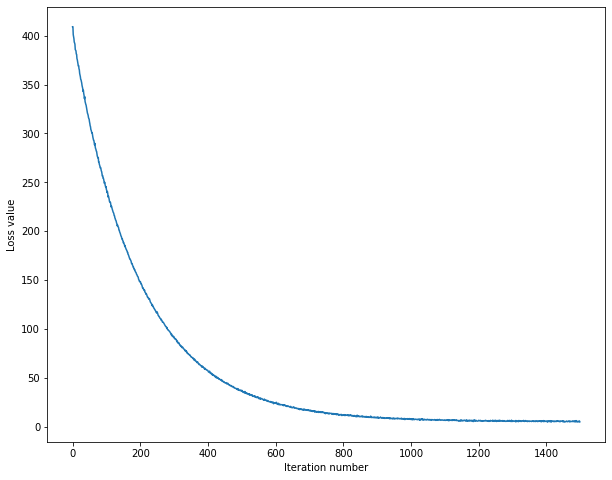

In [14]:
# 一个有用的debugging技巧是把损失函数画出来
plt.plot(loss_hist)
plt.xlabel('Iteration number')
plt.ylabel('Loss value')
plt.show()

In [15]:
# 完成LinearSVM.predict函数,并且在训练集和验证集上评估其准确性
y_train_pred = svm.predict(X_train)
print('training accuracy: %f' % (np.mean(y_train == y_train_pred), ))
y_val_pred = svm.predict(X_val)
print('validation accuracy: %f' % (np.mean(y_val == y_val_pred), ))

training accuracy: 0.380898
validation accuracy: 0.398000


In [18]:
# 使用验证集来调整超参数(正则化强度和学习率)。
# 你可以尝试不同的学习速率和正则化项的值;
# 如果你细心的话,您应该可以在验证集上获得大约0.39的准确率。

# 注意:在搜索超参数时，您可能会看到runtime/overflow的警告。
# 这是由极端超参值造成的,不是代码的bug。

learning_rates = [1e-7, 5e-5]
regularization_strengths = [2.5e4, 5e4]

# results是一个字典,把元组(learning_rate, regularization_strength)映射到元组(training_accuracy, validation_accuracy) 
# accuracy是样本中正确分类的比例
results = {}
best_val = -1   # 我们迄今为止见过最好的验证集准确率
best_svm = None # 拥有最高验证集准确率的LinearSVM对象

##############################################################################
# TODO：
# 编写代码，通过比较验证集的准确度来选择最佳超参数。
# 对于每个超参数组合，在训练集上训练一个线性SVM，在训练集和验证集上计算它的精度，
# 并将精度结果存储在results字典中。此外，在best_val中存储最高验证集准确度，
# 在best_svm中存储拥有此精度的SVM对象。
#
# 提示: 
# 在开发代码时，应该使用一个比较小的num_iter值，这样SVM就不会花费太多时间训练; 
# 一旦您确信您的代码开发完成，您就应该使用一个较大的num_iter值重新训练并验证。
##############################################################################
# *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

for rs in regularization_strengths:
    for lr in learning_rates:
        svm = LinearSVM()
        loss_hist = svm.train(X_train, y_train, lr, rs, num_iters=3000)
        y_train_pred = svm.predict(X_train)
        train_accuracy = np.mean(y_train == y_train_pred)
        y_val_pred = svm.predict(X_val)
        val_accuracy = np.mean(y_val == y_val_pred)
        if val_accuracy > best_val:
            best_val = val_accuracy
            best_svm = svm           
        results[(lr,rs)] = train_accuracy, val_accuracy
            
# *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
    
# 打印results
for lr, reg in sorted(results):
    train_accuracy, val_accuracy = results[(lr, reg)]
    print('lr %e reg %e train accuracy: %f val accuracy: %f' % (
                lr, reg, train_accuracy, val_accuracy))
    
print('best validation accuracy achieved during cross-validation: %f' % best_val)

/content/daseCV/classifiers/linear_svm.py:87: RuntimeWarning: overflow encountered in double_scalars
  loss = np.sum(margins) / num_train + 0.5 * reg * np.sum(W * W)
/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:87: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/content/daseCV/classifiers/linear_svm.py:87: RuntimeWarning: overflow encountered in multiply
  loss = np.sum(margins) / num_train + 0.5 * reg * np.sum(W * W)
/content/daseCV/classifiers/linear_svm.py:85: RuntimeWarning: overflow encountered in subtract
  margins = np.maximum(0, scores - correct_class_scores +1)
/content/daseCV/classifiers/linear_svm.py:85: RuntimeWarning: invalid value encountered in subtract
  margins = np.maximum(0, scores - correct_class_scores +1)
/content/daseCV/classifiers/linear_svm.py:105: RuntimeWarning: overflow encountered in multiply
  dW = dW/num_train + reg*W
/content/daseCV/classifiers/linear_classifier.py:73: Runtime

lr 1.000000e-07 reg 2.500000e+04 train accuracy: 0.380592 val accuracy: 0.387000
lr 1.000000e-07 reg 5.000000e+04 train accuracy: 0.369878 val accuracy: 0.375000
lr 5.000000e-05 reg 2.500000e+04 train accuracy: 0.188796 val accuracy: 0.222000
lr 5.000000e-05 reg 5.000000e+04 train accuracy: 0.100265 val accuracy: 0.087000
best validation accuracy achieved during cross-validation: 0.387000


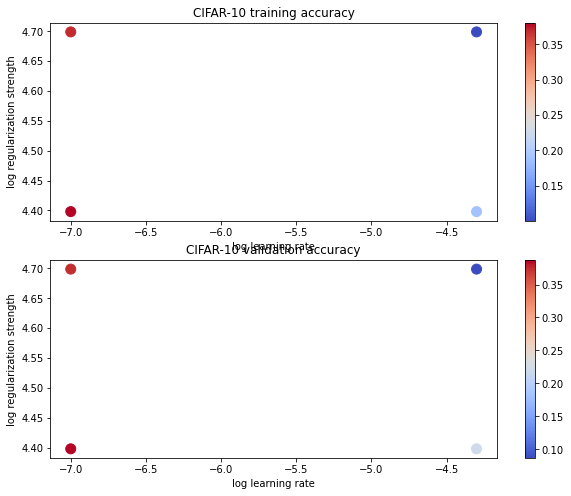

In [19]:
# 可是化交叉验证结果
import math
x_scatter = [math.log10(x[0]) for x in results]
y_scatter = [math.log10(x[1]) for x in results]

# 画出训练集准确率
marker_size = 100
colors = [results[x][0] for x in results]
plt.subplot(2, 1, 1)
plt.scatter(x_scatter, y_scatter, marker_size, c=colors, cmap=plt.cm.coolwarm)
plt.colorbar()
plt.xlabel('log learning rate')
plt.ylabel('log regularization strength')
plt.title('CIFAR-10 training accuracy')

# 画出验证集准确率
colors = [results[x][1] for x in results] # default size of markers is 20
plt.subplot(2, 1, 2)
plt.scatter(x_scatter, y_scatter, marker_size, c=colors, cmap=plt.cm.coolwarm)
plt.colorbar()
plt.xlabel('log learning rate')
plt.ylabel('log regularization strength')
plt.title('CIFAR-10 validation accuracy')
plt.show()

In [20]:
# 在测试集上测试最好的SVM分类器
y_test_pred = best_svm.predict(X_test)
test_accuracy = np.mean(y_test == y_test_pred)
print('linear SVM on raw pixels final test set accuracy: %f' % test_accuracy)

linear SVM on raw pixels final test set accuracy: 0.367000


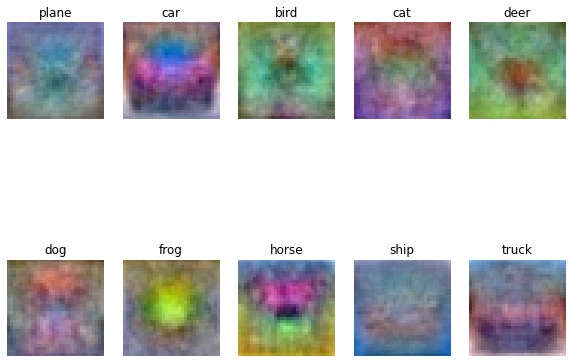

In [21]:
# 画出每一类的权重
# 基于您选择的学习速度和正则化强度，画出来的可能不好看
w = best_svm.W[:-1,:] # 去掉bias
w = w.reshape(32, 32, 3, 10)
w_min, w_max = np.min(w), np.max(w)
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for i in range(10):
    plt.subplot(2, 5, i + 1)
      
    # 将权重调整为0到255之间
    wimg = 255.0 * (w[:, :, :, i].squeeze() - w_min) / (w_max - w_min)
    plt.imshow(wimg.astype('uint8'))
    plt.axis('off')
    plt.title(classes[i])

**问题2**

描述你的可视化权值是什么样子的，并提供一个简短的解释为什么它们看起来是这样的。

$\color{blue}{ 你的回答： }$ 可视化的SVM权重看起来像它们具有相应对象的平均轮廓，这是它们期望响应的。 因为分数是样本与相应权重之间的内在产物，所以如果想在正确的标签中获得更高的分数，则相应的权重应与样本更平行。


---
# 重要

这里是作业的结尾处，请执行以下步骤:

1. 点击`File -> Save`或者用`control+s`组合键，确保你最新的的notebook的作业已经保存到谷歌云。
2. 执行以下代码确保 `.py` 文件保存回你的谷歌云。

In [22]:
import os

FOLDER_TO_SAVE = os.path.join('drive/My Drive/', FOLDERNAME)
FILES_TO_SAVE = ['daseCV/classifiers/linear_svm.py', 'daseCV/classifiers/linear_classifier.py']

for files in FILES_TO_SAVE:
  with open(os.path.join(FOLDER_TO_SAVE, '/'.join(files.split('/')[1:])), 'w') as f:
    f.write(''.join(open(files).readlines()))